In [1]:
import matplotlib
import networkx as nx
import classes as c

def visualize(G):
  nx.draw_spring(G, with_labels = True)
  matplotlib.pyplot.figure(figsize = (200,200))

def removeIsolates(G):
  isolates = list(nx.isolates(G))
  G.remove_nodes_from(isolates)

{0, 2, 4, 5, 7, 9, 11}


In [2]:
def generateNodeString(position, cf, ctp):
  return '[' + str(position) + ',' + str(cf) + ',' + str(ctp) + ']'

In [3]:
def addNodeAndEdge(G, melodyData, curNoteIndex, posOverride = False):
  melody = melodyData['melody']
  lastNoteIndex = len(melody) - 1
  nextCfIndex = curNoteIndex + 1
  prevCf = melody[curNoteIndex]
  if curNoteIndex < lastNoteIndex:
    nextCf = melody[curNoteIndex + 1]
    nextCtps = melodyData[str(nextCf)]
    if posOverride:
      prevCtps = posOverride
    else:
      prevCtps = melodyData[str(nextCf)]
  else:
    nextCf = None
    nextCtp = None
    prevCtps = []
    nextCtps = []
  for prevCtp in prevCtps:
    possStr = generateNodeString(curNoteIndex, prevCf, prevCtp)
    validMoves = []
    if(curNoteIndex < lastNoteIndex):
      for nextCtp in nextCtps:
        """ print(str(prevCf) + " "+ str(nextCf) + " "+ str(prevCtp) + " "+ str(nextCtp)) """
        isValid = c.isValidMove(prevCf, nextCf, prevCtp, nextCtp)
        """ print( prevCf, )
        print(isValid) """
        if(isValid):
          validMoves.append(nextCtp)
    if(validMoves):
      G.add_node(possStr)
      for nextCtp in validMoves:
        newNode = generateNodeString(nextCfIndex, nextCf, nextCtp)
        G.add_node(newNode)
        G.add_edge(possStr, newNode)

In [4]:
def xTheNode(G, finalNote, finalIndex, finalNodes):
  strings = []
  remove = []
  for item in finalNodes:
    string = generateNodeString(finalIndex, finalNote, item)
    strings.append(string)
    for node in G.nodes:
      for item in strings:
        if G.has_node(item):
          isPath = nx.has_path(G, str(node), str(item))
          print("node: " + node + " final: " + item)
          if(not strings.__contains__(node)):
            if not isPath:
              remove.append(node)
              print(str(node) + ' failed')
          else:
            print(str(node))
  for node in remove:
    G.remove_node(node)

In [5]:
def pruneLeaves(G, finalIndex):
  # pseudo code
  # get degrees for all nodes
  degrees = G.degree
  remove = [node for node,degree in dict(G.degree()).items() if degree < 2]
  for node in remove:
    # format node label
    node.replace("[", "")
    node.replace("]", "")
    node.split(",")
    index = node[0]
    # separate string by commas
    # if string[0] is not 0 and is not the final index
    # remove all nodes with degree of 1 ## because they either do not have an edge going out or an edge going in
    if(index != 0) and (index != finalIndex):
      G.remove_node(node)


# potentially remove edges not connected to nodes

In [6]:

def constructInitialGraph(melodyData, willPrint = False):
  melody = melodyData['melody']
  G = nx.DiGraph()
  nx.draw_spectral(G)
  prevNote = None
  curNoteIndex = 0
  finalIndex = len(melody) - 1
  for note in melody:
    nextCf = curNoteIndex + 1
    nextMoves = []
    if(curNoteIndex < finalIndex):
      nextMoves = melodyData[str(melody[nextCf])]
    validMoves = []
    #special cases for first and last nodes
    if(curNoteIndex == 0):
      if melodyData['ctpIsAbove']:
        posCtp = {note + 0, note + 4, note +7, note + 12, note + 16, note + 19}
      else:
        posCtp = {note, note - 12}
      nextMoves = melodyData[str(melody[1])]
      """ print("note: " + str(note) + " posCtp: " + str(posCtp)) """
      addNodeAndEdge(G, melodyData, curNoteIndex, posCtp)
    elif(curNoteIndex == finalIndex):
      if melodyData['ctpIsAbove']:
        finalCtp = {note, note + 12}
      else:
        finalCtp = {note, note - 12}
      addNodeAndEdge(G, melodyData, curNoteIndex, finalCtp)
    else:
      for possCtp in melodyData[str(note)]:
        possString = generateNodeString(curNoteIndex, note, possCtp)
        for move in nextMoves:
          isValid = c.isValidMove(note, melody[nextCf], possCtp, move)
          if(isValid):
            validMoves.append(move)
        if validMoves:
          moveString = generateNodeString(curNoteIndex + 1, melody[curNoteIndex + 1], possCtp)
          G.add_node(moveString)
          for move in validMoves:
            G.add_edge(possString, moveString)
        else:
          if G.has_node(possString):
            G.remove_node(possString)
    curNoteIndex += 1
  xTheNode(G, melody[finalIndex], finalIndex, finalCtp)
  pruneLeaves(G, finalIndex)
  removeIsolates(G)
  pruneLeaves(G, finalIndex)
  removeIsolates(G)
  xTheNode(G, melody[finalIndex], finalIndex, finalCtp)
  removeIsolates(G)
  xTheNode(G, melody[finalIndex], finalIndex, finalCtp)
  if willPrint:
    print(G.nodes)
    print(G.edges)
  return G

{'melody': [0, 5, 4, 9, 7, 5, 4, 2, 0], 'intervalToNext': [5, -1, 5, -2, -2, -1, -2, -2], 'ctpIsAbove': True, '0': [4, 7, 9, 12, 16, 19], '5': [9, 12, 14, 17, 21, 24], '4': [7, 11, 12, 16, 23], '9': [12, 16, 17, 21, 28], '7': [11, 14, 16, 19, 23, 26], '2': [5, 9, 11, 14, 21]}
['[0,0,0]', '[1,5,9]', '[1,5,12]', '[0,0,4]', '[1,5,14]', '[0,0,7]', '[0,0,12]', '[1,5,21]', '[0,0,16]', '[0,0,19]', '[2,4,12]']
[('[0,0,0]', '[1,5,9]'), ('[0,0,0]', '[1,5,12]'), ('[1,5,12]', '[2,4,12]'), ('[0,0,4]', '[1,5,9]'), ('[0,0,4]', '[1,5,14]'), ('[0,0,7]', '[1,5,9]'), ('[0,0,7]', '[1,5,14]'), ('[0,0,12]', '[1,5,9]'), ('[0,0,12]', '[1,5,14]'), ('[0,0,12]', '[1,5,21]'), ('[0,0,16]', '[1,5,9]'), ('[0,0,16]', '[1,5,14]'), ('[0,0,16]', '[1,5,21]'), ('[0,0,19]', '[1,5,9]'), ('[0,0,19]', '[1,5,14]'), ('[0,0,19]', '[1,5,21]')]
DiGraph with 11 nodes and 16 edges


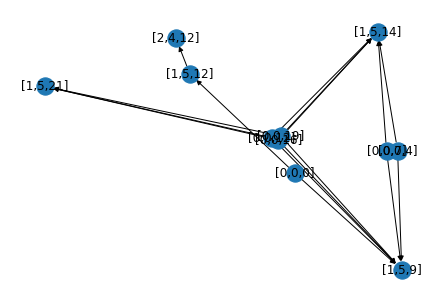

<Figure size 14400x14400 with 0 Axes>

In [7]:
from classes import getAllCombos

combos = getAllCombos([0,5,4,9,7,5,4,2,0], True)
print(combos)
G = constructInitialGraph(combos, True)
visualize(G)
print(G)